In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import bson
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

In [2]:
mouse_data_path='D:\mongofiles\data\mydatabase\mouse_logs.bson'
keyboard_data_path='D:\mongofiles\data\mydatabase\keyboard_usage_logs.bson'

In [3]:
def load_multiple_bson_objects(file_path):
    data = []
    with open(file_path, 'rb') as file:
        for document in bson.decode_all(file.read()):
            data.append(document)
    return data

In [4]:
mouse_data=load_multiple_bson_objects(mouse_data_path)
keyboard_data=load_multiple_bson_objects(keyboard_data_path)

In [5]:
def convert_to_data_frame(row_data):
    data_frames = []
    
    for i in range(len(row_data)):
        current_user = row_data[i]['user_id']
        if row_data == keyboard_data:
            current_data_frame = pd.DataFrame(row_data[i]['events'])
        else:
            current_data_frame = pd.DataFrame(row_data[i]['data'])
        current_data_frame['user_id'] = current_user
        data_frames.append(current_data_frame)

    df = pd.concat(data_frames, ignore_index=True)
    df = df.drop_duplicates()
    return df

In [6]:
mouse_data=convert_to_data_frame(mouse_data)
KeyBoardData=convert_to_data_frame(keyboard_data)

In [7]:
KeyBoardData.shape,  mouse_data.shape

((1984, 4), (15451, 10))

In [8]:
mouse_data.columns

Index(['time', 'elapsed_time', 'event', 'x', 'y', 'velocity', 'acceleration',
       'direction', 'click_duration', 'user_id'],
      dtype='object')

In [9]:
KeyBoardData.columns

Index(['event', 'key', 'timestamp', 'user_id'], dtype='object')

In [10]:
mouse_data.set_index('time',inplace=True)
KeyBoardData.set_index('timestamp',inplace=True)

In [11]:
mouse_data.index = pd.to_datetime(mouse_data.index)

mouse_data['day_of_week'] = mouse_data.index.dayofweek
mouse_data['hour_of_day'] = mouse_data.index.hour
mouse_data['minute_of_hour'] = mouse_data.index.minute

lagged_features = ['x', 'y', 'velocity', 'acceleration']
for feature in lagged_features:
    mouse_data[f'{feature}_lag1'] = mouse_data[feature].shift(1)

mouse_data['velocity_rolling_mean'] = mouse_data['velocity'].rolling(window=5).mean()

mouse_data['hour_sin'] = np.sin(2 * np.pi * mouse_data['hour_of_day']/24)
mouse_data['hour_cos'] = np.cos(2 * np.pi * mouse_data['hour_of_day']/24)
mouse_data['day_of_week_sin'] = np.sin(2 * np.pi * mouse_data['day_of_week']/7)
mouse_data['day_of_week_cos'] = np.cos(2 * np.pi * mouse_data['day_of_week']/7)

In [12]:
mouse_data.head()

,elapsed_time,event,x,y,velocity,acceleration,direction,click_duration,user_id,day_of_week,...,minute_of_hour,x_lag1,y_lag1,velocity_lag1,acceleration_lag1,velocity_rolling_mean,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos
time,,,,,,,,,,,,,,,,,,,,,
2024-05-08 23:59:06.364,272,Move,45,269,NaN,NaN,NaN,NaN,66322d94f89c7cd14b365ea8,2,...,59,NaN,NaN,NaN,NaN,NaN,-0.258819,0.965926,0.974928,-0.222521
2024-05-08 23:59:06.372,280,Move,76,281,0.000000,0.000000,0.000000,0.0,66322d94f89c7cd14b365ea8,2,...,59,45.0,269.0,NaN,NaN,NaN,-0.258819,0.965926,0.974928,-0.222521
2024-05-08 23:59:06.379,288,Move,106,291,3952.847075,3952.847075,18.434949,8.0,66322d94f89c7cd14b365ea8,2,...,59,76.0,281.0,0.000000,0.000000,NaN,-0.258819,0.965926,0.974928,-0.222521
2024-05-08 23:59:06.386,295,Move,131,301,3846.546291,-560845.893025,21.801409,7.0,66322d94f89c7cd14b365ea8,2,...,59,106.0,291.0,3952.847075,3952.847075,NaN,-0.258819,0.965926,0.974928,-0.222521
2024-05-08 23:59:06.393,302,Move,154,312,3642.156795,-545864.456177,25.559965,7.0,66322d94f89c7cd14b365ea8,2,...,59,131.0,301.0,3846.546291,-560845.893025,NaN,-0.258819,0.965926,0.974928,-0.222521


In [13]:
label_encoder = LabelEncoder()
mouse_data['user_id'] = label_encoder.fit_transform(mouse_data['user_id'])
mouse_data['event'] = label_encoder.fit_transform(mouse_data['event'])
mouse_data.rename(columns={'event': 'mouse_event'}, inplace=True)

In [14]:
mouse_data.reset_index(drop=True,inplace=True)

In [15]:
mouse_data.replace('null', pd.NA, inplace=True)
imputer = SimpleImputer(strategy='mean')
mouse_data = pd.DataFrame(imputer.fit_transform(mouse_data), index=mouse_data.index, columns=mouse_data.columns)
mouse_data.dropna(inplace=True)

# process keyBoardData

In [16]:
label_encoder = LabelEncoder()
KeyBoardData['key'] = label_encoder.fit_transform(KeyBoardData['key'])
KeyBoardData['event'] = label_encoder.fit_transform(KeyBoardData['event'])
KeyBoardData.rename(columns={'event': 'keyboard_event'}, inplace=True)

KeyBoardData.index = pd.to_datetime(KeyBoardData.index)
# new test wihtout milliseconds
KeyBoardData['day_of_week'] = KeyBoardData.index.dayofweek
KeyBoardData['hour_of_day'] = KeyBoardData.index.hour
KeyBoardData['minute_of_hour'] = KeyBoardData.index.minute

KeyBoardData['key_lag1'] = KeyBoardData['key'].shift(1)

KeyBoardData['hour_sin'] = np.sin(2 * np.pi * KeyBoardData['hour_of_day']/24)
KeyBoardData['hour_cos'] = np.cos(2 * np.pi * KeyBoardData['hour_of_day']/24)
KeyBoardData['day_of_week_sin'] = np.sin(2 * np.pi * KeyBoardData['day_of_week']/7)
KeyBoardData['day_of_week_cos'] = np.cos(2 * np.pi * KeyBoardData['day_of_week']/7)


In [17]:
label_encoder = LabelEncoder()
KeyBoardData['user_id'] = label_encoder.fit_transform(KeyBoardData['user_id'])

In [18]:
mouse_data.drop(columns=['user_id'], inplace=True)

if not KeyBoardData.index.is_unique:
    KeyBoardData = KeyBoardData.reset_index()

mouse_data = mouse_data.iloc[:1900, :]
KeyBoardData = KeyBoardData.iloc[:1900, :]

In [19]:
result_df = pd.concat([KeyBoardData, mouse_data], axis=1)

In [20]:
result_df.columns

Index(['timestamp', 'keyboard_event', 'key', 'user_id', 'day_of_week',
       'hour_of_day', 'minute_of_hour', 'key_lag1', 'hour_sin', 'hour_cos',
       'day_of_week_sin', 'day_of_week_cos', 'elapsed_time', 'mouse_event',
       'x', 'y', 'velocity', 'acceleration', 'direction', 'click_duration',
       'day_of_week', 'hour_of_day', 'minute_of_hour', 'x_lag1', 'y_lag1',
       'velocity_lag1', 'acceleration_lag1', 'velocity_rolling_mean',
       'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos'],
      dtype='object')

In [21]:
result_df.set_index('timestamp',inplace=True)

In [22]:
feature_columns = ['keyboard_event', 'key', 'day_of_week', 'hour_of_day', 'minute_of_hour', 'key_lag1',
                   'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'elapsed_time','mouse_event',
                   'x', 'y', 'velocity', 'acceleration', 'direction', 'click_duration',
                   'x_lag1', 'y_lag1', 'velocity_lag1', 'acceleration_lag1', 'velocity_rolling_mean',
                  'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',]
result_df.fillna(0, inplace=True)

X = result_df[feature_columns]
y = result_df['user_id']


In [23]:
result_df.columns

Index(['keyboard_event', 'key', 'user_id', 'day_of_week', 'hour_of_day',
       'minute_of_hour', 'key_lag1', 'hour_sin', 'hour_cos', 'day_of_week_sin',
       'day_of_week_cos', 'elapsed_time', 'mouse_event', 'x', 'y', 'velocity',
       'acceleration', 'direction', 'click_duration', 'day_of_week',
       'hour_of_day', 'minute_of_hour', 'x_lag1', 'y_lag1', 'velocity_lag1',
       'acceleration_lag1', 'velocity_rolling_mean', 'hour_sin', 'hour_cos',
       'day_of_week_sin', 'day_of_week_cos'],
      dtype='object')

In [24]:
tscv = TimeSeriesSplit(n_splits=5)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

cv_scores = cross_val_score(rf,X_train,y_train, cv=5, scoring='accuracy')
tscv_scores = cross_val_score(rf,X_train,y_train, cv=tscv, scoring='accuracy')

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
print("Classification Report: \n", classification_report(y_test, y_pred))

print("Cross-validation scores: ", cv_scores)
print("Mean accuracy: ", np.mean(cv_scores))
print("Standard deviation of accuracy: ", np.std(cv_scores))

print("TimeSeriesSplit cross-validation scores: ", tscv_scores)
print("Mean TimeSeriesSplit accuracy: ", np.mean(tscv_scores))
print("Standard deviation of TimeSeriesSplit accuracy: ", np.std(tscv_scores))

feature_importances = rf.feature_importances_


Accuracy:  0.9973684210526316
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00       333
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         2
           5       0.96      1.00      0.98        23
           6       1.00      0.67      0.80         3

    accuracy                           1.00       380
   macro avg       0.99      0.95      0.97       380
weighted avg       1.00      1.00      1.00       380

Cross-validation scores:  [0.99013158 0.99671053 0.98684211 0.99671053 0.99013158]
Mean accuracy:  0.9921052631578947
Standard deviation of accuracy:  0.0039473684210526395
TimeSeriesSplit cross-validation scores:  [0.94466403 0.98814229 0.98418972 0.99604743 0.99604743]
Mean TimeSeriesSplit accuracy:  0.9818181818181818
Standard deviation of Tim

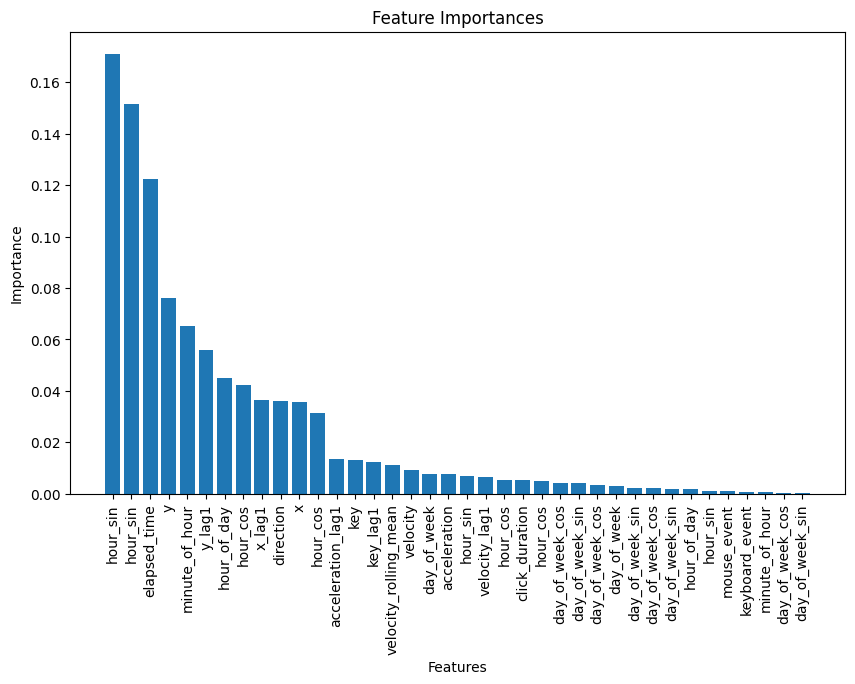

In [27]:
feature_importances = rf.feature_importances_
feature_names = X_train.columns
sorted_indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(feature_importances)), feature_names[sorted_indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

In [28]:
# stop here right now